# **BLACK-SCHOLES MODEL**
[Black-Scholes model basics](https://www.investopedia.com/terms/b/blackscholes.asp)

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**IMPORTING THE LIBRARIES**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import date

import warnings
warnings.filterwarnings("ignore")

# to fetch data 
import yfinance as yf

import scipy.stats as ss

**IMPORTING DATA**

In [3]:
symbol = '^SPX'
end = date.today()
start = end.replace(year = 2022)

tickerData = yf.Ticker(symbol)

# Read data 
df = tickerData.history(period='1d', start=start, end=end, interval = '1d')


df.tail()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-05-16 00:00:00-04:00,4127.950195,4135.540039,4109.859863,4109.899902,3654200000,0.0,0.0
2023-05-17 00:00:00-04:00,4122.850098,4164.669922,4113.620117,4158.770020,4039080000,0.0,0.0
2023-05-18 00:00:00-04:00,4157.680176,4202.200195,4153.500000,4198.049805,3980500000,0.0,0.0
2023-05-19 00:00:00-04:00,4204.149902,4212.910156,4180.200195,4191.979980,4041900000,0.0,0.0
2023-05-22 00:00:00-04:00,4190.779785,4209.220215,4179.680176,4192.629883,3728520000,0.0,0.0


In [5]:
symbol = '^SPX'  #the ticker of the stock whose data is to be taken out
dfo = yf.Ticker(symbol)

In [6]:
dfo.options  #to get the date of different expiration time

('2023-05-23',
 '2023-05-24',
 '2023-05-25',
 '2023-05-26',
 '2023-05-30',
 '2023-05-31',
 '2023-06-01',
 '2023-06-02',
 '2023-06-05',
 '2023-06-06',
 '2023-06-07',
 '2023-06-08',
 '2023-06-09',
 '2023-06-12',
 '2023-06-13',
 '2023-06-14',
 '2023-06-15',
 '2023-06-16',
 '2023-06-20',
 '2023-06-23',
 '2023-06-26',
 '2023-06-30',
 '2023-07-03',
 '2023-07-07',
 '2023-07-21',
 '2023-07-31',
 '2023-08-18',
 '2023-08-31',
 '2023-09-15',
 '2023-09-29',
 '2023-10-20',
 '2023-10-31',
 '2023-11-17',
 '2023-12-15',
 '2023-12-29',
 '2024-01-19',
 '2024-02-16',
 '2024-03-15',
 '2024-03-28',
 '2024-04-19',
 '2024-05-17',
 '2024-06-21',
 '2024-12-20',
 '2025-12-19',
 '2026-03-20',
 '2026-12-18',
 '2027-12-17')

In [7]:
dfo_exp = dfo.option_chain(dfo.options[1])  #you can change index to try on different expiry dates

In [8]:
dfo_exp.calls.head() #data for call options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPXW230524C01200000,2023-05-22 13:46:07+00:00,1200.0,3001.83,2996.0,2997.7,0.0,0.0,1.0,0,7.322266,True,REGULAR,USD
1,SPXW230524C01400000,2023-05-18 08:00:15+00:00,1400.0,2763.20,2796.6,2798.0,0.0,0.0,1.0,0,6.546389,True,REGULAR,USD
2,SPXW230524C02600000,2023-05-19 14:39:59+00:00,2600.0,1610.32,1596.2,1597.9,0.0,0.0,1.0,0,3.033694,True,REGULAR,USD
3,SPXW230524C03100000,2023-05-19 14:39:59+00:00,3100.0,1110.62,1097.0,1098.4,0.0,0.0,1.0,0,2.070317,True,REGULAR,USD
4,SPXW230524C03600000,2023-05-22 18:35:00+00:00,3600.0,603.48,597.1,598.5,0.0,0.0,3.0,0,1.164128,True,REGULAR,USD


# **CALCULATION OF ANNUAL VOLATALITY**
Annual volatility of the stock can be calculated as:

Calculating daily logarithmic returns

Then calculating its standard deviation to get daily volatility

Then multiplying it by sqrt(252) as there are 252 trading days in a year.

In [9]:
def annual_vol(df):
    """
    Function to calculate annual volatility
    
    Parameters
    ----------
    df : dataframe
         Stock info

    Returns
    -------
    vol : float
        annual volatility of the stock
    """
    
    log_return = np.log(df['Close']) - np.log(df['Close'].shift(1))
    log_return = log_return[1:]  #to remove nan 
    daily_vol = log_return.std()
    vol = daily_vol*(252**0.5)
    
    return vol

In [10]:
vol = annual_vol(df)
vol

0.21141967731757907

# **BLACK-SCHOLES MODEL**


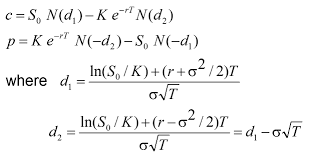

C : call option price

P : Put option price

S : Stock price

K : Strike price

r : risk free rate

t : time of maturity in year

N = Normal distribution

In [11]:
def euro_vanilla(S, K, T, r, sigma, option = 'call'):
    """
    To calculate options price with the help of black-scholes model
    
    Parameters
    ----------
    S : float
        The price of the underlying
    
    K : float
        Strike price of the option
        
    T : float
        Time to expiry in years
        
    r : float
        Risk free rate which can be taken as the US Treasury bond yield
        
    sigma : float
        The annual volatility of the returns
        
    option : string
        call for call option
        put for put option
    
    Returns
    -------
    premium : float
        The price of call or put option
    """
    
    
    d1 = (np.log(S/K) + (r + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option == 'call':
        premium = S * ss.norm.cdf(d1) - K * np.exp(-r * T) * ss.norm.cdf(d2)
    if option == 'put':
        premium =  K * np.exp(-r * T) * ss.norm.cdf(-d2) - S * ss.norm.cdf(-d1)
        
    return premium

In [12]:
N = 100
T = 8.0/365      #Calculate the number of days left for expiry from your calculation in years
t = T/N       

In [13]:
#r is the risk free rate taken from the 10 years us treasury bond
#call price calculated from black scholes model
call = {}
for K in dfo_exp.calls['strike']:
    call_price = euro_vanilla(S = df['Close'][len(df)-1], K = K, T = T, r=0.0123*t, sigma=vol)
  # print(call_price)
    call[K] = call_price
th_call = pd.DataFrame.from_dict(call, orient='index')
th_call.rename(columns = {0:"th_call"}, inplace = True)
th_call.head()

,th_call
1200.0,2992.629954
1400.0,2792.629966
2600.0,1592.630036
3100.0,1092.630066
3600.0,592.630109


In [14]:
#actual call price
ac_call = dfo_exp.calls.loc[:, ['strike', 'lastPrice']]
ac_call.set_index('strike', inplace = True)
ac_call.rename(columns = {"lastPrice":"ac_call"}, inplace=True)
ac_call.head()

,ac_call
strike,
1200.0,3001.83
1400.0,2763.20
2600.0,1610.32
3100.0,1110.62
3600.0,603.48


In [15]:
call = th_call
call["ac_call"] = ac_call
call.head(10)

,th_call,ac_call
1200.0,2992.629954,3001.83
1400.0,2792.629966,2763.20
2600.0,1592.630036,1610.32
3100.0,1092.630066,1110.62
3600.0,592.630109,603.48
3700.0,492.631008,502.83
3750.0,442.635706,437.88
3900.0,293.078053,285.81
3920.0,273.347950,208.14
3940.0,253.752702,201.27


<Axes: >

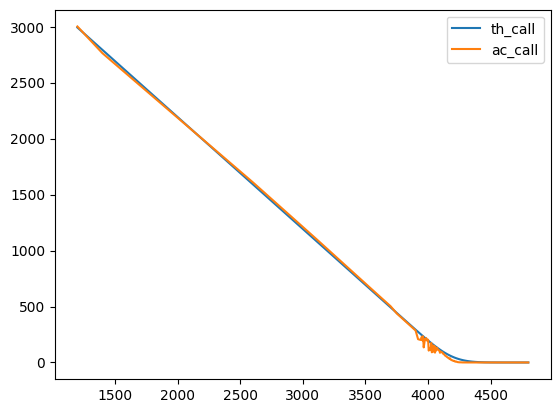

In [16]:
call.plot() #plotting the actual and theoretical call prices

In [17]:
#r is the risk free rate taken from the 10 years us treasury bond
#theoretical put price calculated from black scholes model
put = {}
for K in dfo_exp.puts['strike']:
    put_price = euro_vanilla(S = df['Close'][len(df)-1], K = K, T = T, r=0.0158*t, sigma=vol, option = 'put')
  # print(put_price)
    put[K] = put_price
th_put = pd.DataFrame.from_dict(put, orient='index')
th_put.rename(columns = {0:"th_put"}, inplace = True)
th_put.head()

,th_put
2200.0,5.932075e-94
2400.0,1.296753e-70
2600.0,4.341834e-52
2800.0,1.896321e-37
3000.0,5.551934e-26


In [18]:
#actual put price
ac_put = dfo_exp.puts.loc[:, ['strike', 'lastPrice']]
ac_put.set_index('strike', inplace = True)
ac_put.rename(columns = {"lastPrice":"ac_put"}, inplace=True)
ac_put.head()

,ac_put
strike,
2200.0,0.05
2400.0,0.05
2600.0,0.05
2800.0,0.05
3000.0,0.05


In [19]:
put = th_put
put["ac_put"] = ac_put
put.tail(10)

,th_put,ac_put
4275.0,103.945052,78.05
4280.0,107.665300,82.85
4300.0,123.123273,105.70
4310.0,131.175589,103.44
4325.0,143.620363,118.18
4340.0,156.463842,154.24
4350.0,165.225186,247.45
4400.0,210.944064,206.30
4800.0,607.369982,613.74
5200.0,1007.369722,996.97


<Axes: >

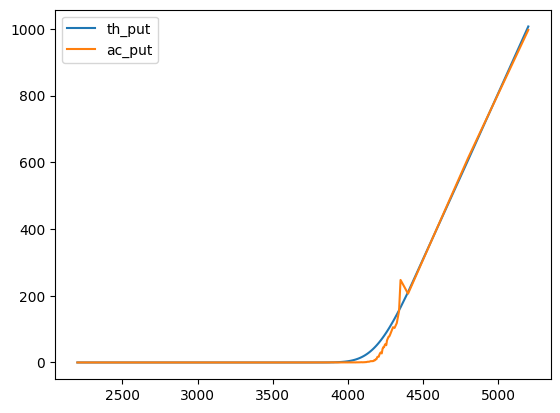

In [30]:
put.plot()